# Results Analysis

Use to generate figures with explorea and illustrate trends in our results.
- [ ] TFPN versus size
- [ ] runtime & memory analysis
- [ ] HParam sensitivity analysis (sensitivity matrix per hparam?)

## Runtime and Memory Analysis

Question: How burdensome is the method (comparable cross-platform) and which parts of the method are the most burdensome?

Purpose: Sets expectation for applicability; allows for comparison against future methods

Conflating factors: 
- depends on sensitivity of hparams
- depends on filters being used
- depends on size of video snippet

Solution:
- use 20, 75, 88 hparams and average? (keep it simple: just 1 number to report)
- report each filter stage's contribution to overall?
- average over entire train set? (test is longer, and best to keep separate for future users?)

Tools:
- python_papi... X: error on pip install

In [43]:
import sys, os, logging
from math import ceil, floor
import json
from pathlib import Path
from typing import List, Tuple, Union, Dict, Optional
from multiprocessing import Process, Pool
import psutil
import base64
import asyncio
import cv2
import imageio as iio
import numpy as np
from IPython.core.display import HTML
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq, fftn, fftshift
from pprint import pprint

from turbx import REPO_PATH, log
from turbx.vis import (calc_tfpnr, calc_tdr, calc_frames_removed, label_to_per_frame_list)
from turbx.metrics import (
    calc_box_area,
    avg_box_area,
    boxes_to_binary,
    target_detection_rate,
    tfpnr,
    safe_division
)

In [44]:
# SEE PROFILE_MULTIRUN.PY

In [45]:

#def calc_avg_target_size(tracks, preds):
#    '''
#        Per target avg size
#    '''
#    out = []
#    for track in tracks:
#        out.append(mean([calc_area(frame['box']) for frame in track['frames']]))
#    return out

## Performance VS Size Analysis

Calculate TPFN per target then plot/averge by size?

### Set Data Path

In [46]:
#base_path = Path(f"{REPO_PATH}/notebooks/outputs/ablation/2022-12-23/22-38-06")
# test - all layers
#base_path = Path(f"{REPO_PATH}/notebooks/outputs/ablation/2022-12-16/12-25-41/2")
# train - all layers
base_path = Path(f"{REPO_PATH}/notebooks/outputs/with-tracklets/train/88")

### Calculate Metrics
Note:
- TP/FN indicate a model's ability to detect a target in view
- TN/FP indicate a model's ability to distinguish noise from signal

Desired values:
- Per frame w/ target size and TP/FN -> plot over all sizes, or bin and average to capture trend
- Per frame w/o target TN/FP -> average over train vs test

In [47]:

# calculate per video scores

# Things we want per run,
# 1) mAR
# 2) mAP
# 3) F1
# 4) TDR - if this is not 1 then we can adjust this param search
# TDR can be tought of as the notification rate, we really do not want to miss a notification

all_neg_dets= 0
all_neg_lab= 0
all_frames =0


maxF1 = 0
maxAP = 0
maxAR = 0
maxFramesRemoved = 0
maxTDR = 0
APs = []
ARs = []
F1s = []
FRs = []
TDRs = []
satisfies_criterion_param_set = []
satisfies_criterion = []
maxAVGFRTDRParamID = None
maxAVGFRTDRIDX = None
maxAVGFRTDR = 0

args_json = Path(base_path / "args.json")
if args_json.exists():
    with open(str(args_json), 'r') as f:
        pprint(json.load(f))

#print("Per frame:")
#print("id:, FPR, FNR, Target Detection Rate, % Frames Removed, % Neg Frames Removed")
pos_frames, neg_frames = [], []
pos_preds, neg_preds = [], []

# accumulate run directories
subdirs = next(os.walk(str(base_path)))[1]
param_set_path = base_path
param_set_results = []
param_set = param_set_path.name
# load every json for that run and append to param_set_results
for f_name in param_set_path.glob("**/*.json"):
    with open(f_name, 'r') as f:
        params = json.load(f)
        param_set_results.append((params, param_set))
tp = 0
fp = 0
fn = 0
all_neg_dets = 0
all_neg_lab = 0
all_frames = 0
tdrsum=0

# for each video
for result, param_set_id in param_set_results[2:]:
    
    # per frame binary label and pred
    binary_label, binary_pred, _ = calc_tfpnr(result['label'], result['prediction'], show=False, save=False)

    # per frame list of avg box area
    avg_box_area_per_frame = [avg_box_area(box) for box in label_to_per_frame_list(result['label'])]
    
    # create list of all binary labels and preds for positive and negative frames combined with bounding boxe areas
    y = zip(binary_label, binary_pred, avg_box_area_per_frame)
    for x in y:
        if x[0] == 1:
            pos_frames.append(x)
            pos_preds.append((int(x[0] == x[1]), x[2]))
        else:
            neg_frames.append(x)
            neg_preds.append(int(x[0] == x[1])) 

print(len(pos_frames))
print(len(neg_frames))
print(len(pos_preds))
print(len(neg_preds))

596
3214
596
3214


[(0, 1426.0), (0, 1426.0), (0, 1426.0), (0, 1426.0), (0, 1426.0), (0, 1426.0), (0, 1426.0), (0, 1395.0), (0, 1196.0), (1, 1058.0), (1, 1058.0), (1, 1885.0), (1, 1885.0), (1, 1885.0), (1, 1885.0), (1, 1716.0), (1, 1716.0), (1, 1716.0), (1, 1716.0), (1, 1716.0)]


(array([121.,  30.,   8.,   5.,   5.,  19.,   1.,   1.,   7.,   0.,   4.,
          1.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   8.,   4.,   0.,   0.,   0.,   2.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([   63.  ,   293.54,   524.08,   754.62,   985.16,  1215.7 ,
         1446.24,  1676.78,  1907.32,  2137.86,  2368.4 ,  2598.94,
         2829.48,  3060.02,  3290.56,  3521.1 ,  3751.64,  3982.18,
         4212.72,  4443.26,  4673.8 ,  4904.34,  5134.88,  5365.42,
         5595.96,  5826.5 ,  6057.04,  6287.58,  6518.12,  6748.66,
         6979.2 ,  7209.74,  7440.28,  7670.82,  7901.36,  8131.9 ,
         8362.44,  8592.98,  8823.52,  9054.06,  9284.6 ,  9515.14,
         9745.68,  9976.22, 10206.76, 10437.3 , 10667.84, 10898.38,
        11128.92, 11359.46, 11590.  ]),
 <BarContainer object of 50 artists>)

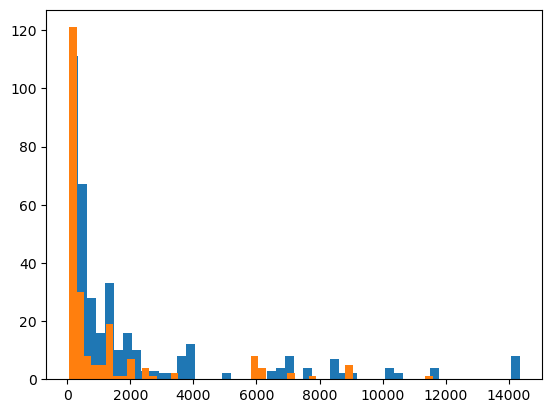

In [48]:
print(pos_preds[:20])
fig, ax = plt.subplots()
true_pos_preds = [x[1] for x in pos_preds if x[0] == 1]
false_pos_preds = [x[1] for x in pos_preds if x[0] == 0]
#ax.scatter([x[1] for x in pos_preds], [x[0] for x in pos_preds], )
ax.hist(true_pos_preds, bins=50)
ax.hist(false_pos_preds, bins=50)
#ax.set_xscale("log")


[(0, 1426.0), (0, 1426.0), (0, 1426.0), (0, 1426.0), (0, 1426.0), (0, 1426.0), (0, 1426.0), (0, 1395.0), (0, 1196.0), (1, 1058.0), (1, 1058.0), (1, 1885.0), (1, 1885.0), (1, 1885.0), (1, 1885.0), (1, 1716.0), (1, 1716.0), (1, 1716.0), (1, 1716.0), (1, 1716.0)]


<BarContainer object of 8 artists>

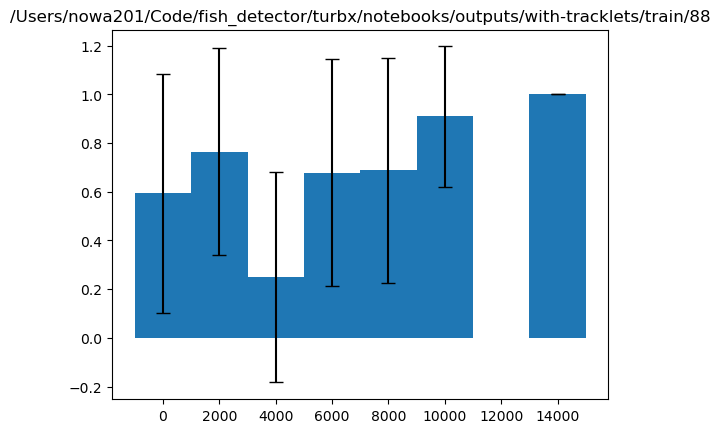

In [49]:
print(pos_preds[:20])
sorted_pos_preds = sorted(pos_preds, key=lambda x: x[1])

# bin preds by size
bin_size = 2000
binned_list = [[] for x in range(ceil(max([y[1] for y in pos_preds])/bin_size))]
for x in pos_preds:
    bin = floor(x[1]/bin_size)
    binned_list[bin].append(x)

bin_stats = []
for idx, bin in enumerate(binned_list):
    bin_preds = [x[0] for x in bin]
    bin_sizes = [x[1] for x in bin]
    bin_mean = np.mean(bin_preds)
    bin_std = np.std(bin_preds)
    bin_stats.append((bin_mean, bin_std, (idx*bin_size, (idx+1)*bin_size)))

fig, ax = plt.subplots()
# x_start, height, width (list of 100s)
plt.title(f"{base_path}")
plt.bar([x[2][0] for x in bin_stats], height=[x[0] for x in bin_stats], width=[bin_size for _ in bin_stats], yerr=[x[1] for x in bin_stats], ecolor='black', capsize=5)
#true_pos_preds = [x[1] for x in pos_preds if x[0] == 1]
#false_pos_preds = [x[1] for x in pos_preds if x[0] == 0]
#ax.scatter([x[1] for x in pos_preds], [x[0] for x in pos_preds], )
#ax.hist(true_pos_preds, bins=50)
#ax.hist(false_pos_preds, bins=50)
#ax.set_xscale("log")

### Plot TP/FN vs. Target Size
Guiding question:
- Does our TP rate decrease with size?

### Plot TN/FP for Train and Test
Guiding question:
- Does our FP rate differ between the two sets? -> one contains more noise than the other